In [100]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
import re
import os
import seaborn as sns
from matplotlib import cm, colors

In [101]:
PATH = os.getcwd()
TEST_FOLDER = 'test-result'
REGGRESSION_FOLDER = 'regressions'
PARAMETRIC_FOLDER = 'parametric'
ACENTUACION_FOLDER = 'Acentuacion'
CADENCIA_FOLDER = 'Cadencia'
INTELIGIBILIDAD_FOLDER = 'Inteligibilidad'
NATURALIDAD_FOLDER = 'Naturalidad'
PRONUNCIACION_FOLDER = 'Pronunciacion'
MALE_FOLDER = 'masculino'
FEMALE_FOLDER = 'femenino'

In [102]:
# Diccionario para guardar los p-value
dicc_p_value = {
    'subjetive_parameter':[],
    'ZCR':[],
    'RMS':[],
    'f0':[],
    'selected_features':[],
    'genero':[] 
}

In [103]:
# Voy a limpiar los graficos que hay en las carpetas

list_files = os.listdir(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER))

list_folder = []
for folder in list_files:
    if not folder.endswith('.xlsx'):
        list_folder.append(folder)
        
SUBFOLDER_GENDER = ['masculino', 'femenino']

for folder in list_folder:
    for gender in SUBFOLDER_GENDER:
        os.chdir(os.path.join(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, folder, gender)))
        all_files = os.listdir()
        if len(all_files) == 0:
            continue
        for f in all_files:
            os.remove(f)

os.chdir(PATH)

In [104]:
list_folder

['Acentuacion', 'Cadencia', 'Inteligibilidad', 'Naturalidad', 'Pronunciacion']

In [105]:
merged_df = pd.read_csv(r'aux_file\data_regression.csv')

In [106]:
obj_params = pd.read_excel('voces_test_rms.ods')

In [107]:
obj_params.head()

,zero_crossing_rate,rms,mfcc,pitch,genero,file
0,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino,hyacinthe-lovo-v3.wav
1,0.093035,-27.0,[-424.61664 138.61742 -14.495688 3...,101.312090,femenino,lola-murf.wav
2,0.093043,-22.5,[-3.71418152e+02 1.31561859e+02 -1.60284328e+...,76.492752,masculino,neural2B-GCP.wav
3,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino,alonso-naturalreader.wav
4,0.105458,-21.5,[-3.5115176e+02 1.1943483e+02 -1.9279911e+01 ...,69.045778,masculino,antonio-murf.wav


In [108]:
df_union = pd.merge(
    merged_df,
    obj_params,
    how='left',
    left_on='filename',
    right_on='file'
).drop(columns=['file'])

In [109]:
df_union.rename(
    columns={
        'zero_crossing_rate': 'zcr',
        'pitch': 'f0'
    },
    inplace=True
)

In [110]:
df_union.head()

,ID,filename,Inteligibilidad,Pronunciacion,Acentuacion,Naturalidad,Cadencia,zcr,rms,mfcc,f0,genero
0,1,alonso-naturalreader.wav,4.892857,4.636364,4.482143,3.142857,3.803571,0.098051,-22.0,[-3.4943588e+02 1.2940279e+02 -1.8956478e+01 ...,68.726911,masculino
1,2,hyacinthe-lovo-v3.wav,4.964286,4.698113,4.553571,4.232143,4.196429,0.075944,-27.5,[-4.0729132e+02 1.3076346e+02 -3.0420111e+01 ...,111.111716,femenino
2,3,neural2C-pitchmodified-speedmodified.wav,4.509434,3.914894,2.892857,1.821429,1.750000,0.251626,-25.0,[-4.4141333e+02 8.9362648e+01 -1.2164741e+01 ...,98.468505,masculino
3,4,francisca-lovo-v2.wav,4.732143,4.320755,4.303571,3.107143,3.803571,0.137822,-26.1,[-454.8679 72.41395 -14.8625145 45.9...,116.353345,femenino
4,5,antoni-evenlabs-linguistico-v2.wav,4.636364,4.098039,3.267857,1.910714,1.732143,0.239188,-24.0,[-406.19888 84.30505 -12.89493 18.8...,78.968152,masculino


## SelectorFeature

In [111]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.utils import check_random_state
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

### Inteligibilidad

In [112]:
df_inteligibilidad = df_union.loc[:, ['Inteligibilidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [113]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'masculino'

df_inteligibilidad_male = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [114]:
# Cargamos los datos
X = np.array(df_inteligibilidad_male.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_male.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.1301
Característica RMS: p-valor = 0.5761
Característica f0: p-valor = 0.6992


In [115]:
selected_features

(0,)

In [116]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [117]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.49 * ZCR + 5.07 - p-valor = 0.130


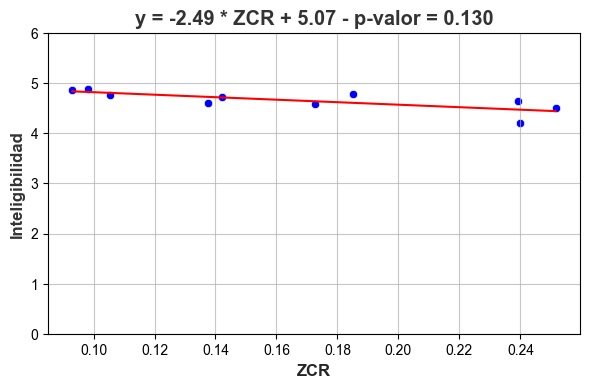

In [118]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresiones_inteligibilidad_male.png'))
    plt.show()


In [119]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-28, -26, -24, -22])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, MALE_FOLDER, 'regresion_inteligibilidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [120]:
# Lista de p-values
p_values = []

mask_gender = df_inteligibilidad.genero == 'femenino'

df_inteligibilidad_female = df_inteligibilidad[mask_gender].drop(columns=['genero'])

In [121]:
# Cargamos los datos
X = np.array(df_inteligibilidad_female.drop(columns=['Inteligibilidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_inteligibilidad_female.Inteligibilidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Inteligibilidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.0267
Característica RMS: p-valor = 0.6728
Característica f0: p-valor = 0.1272


In [122]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [123]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.38 * ZCR + 5.11 - p-valor = 0.027
y = -0.00 * $f_{0}$ + 5.06 - p-valor = 0.127


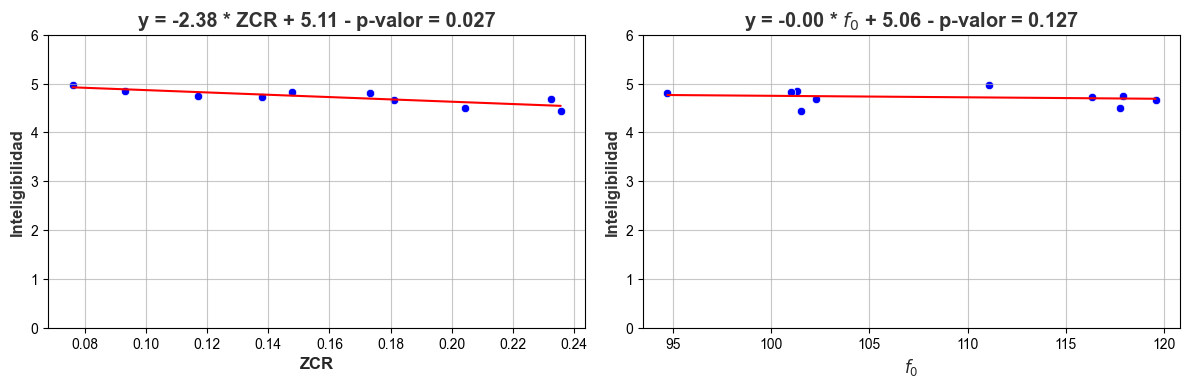

In [124]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Inteligibilidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(
        os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_inteligibilidad_female.png')
    )
    plt.show()


In [125]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Inteligibilidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, INTELIGIBILIDAD_FOLDER, FEMALE_FOLDER, 'regresion_inteligibilidad_multivariable_female.html')
    )

    fig.show()


### Pronunciacion

In [126]:
df_pronunciacion = df_union.loc[:, ['Pronunciacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [127]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'masculino'

df_pronunciacion_male = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [128]:
# Cargamos los datos
X = np.array(df_pronunciacion_male.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_male.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 1)
Característica ZCR: p-valor = 0.0023
Característica RMS: p-valor = 0.0124
Característica f0: p-valor = 0.1186


In [129]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [130]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -3.26 * ZCR + 4.86 - p-valor = 0.002
y = 0.07 * RMS + 5.83 - p-valor = 0.012


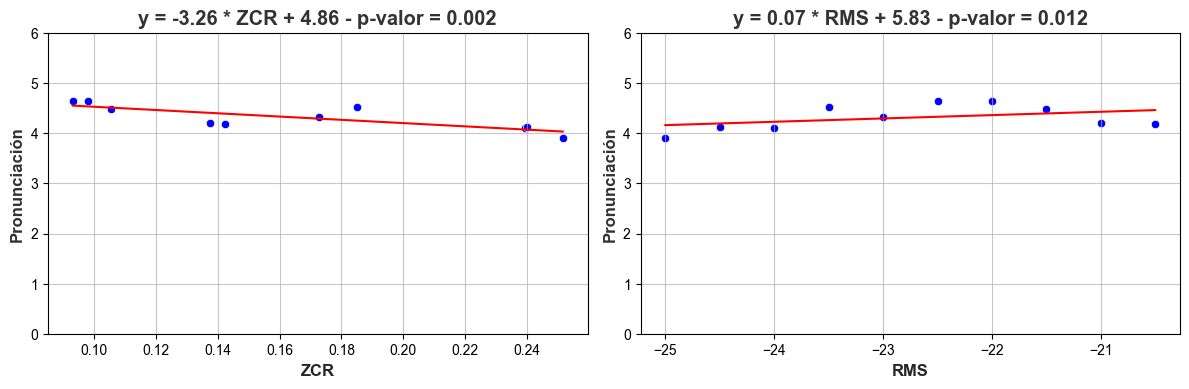

In [131]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresiones_pronunciacion_male.png'))
    plt.show()


In [132]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, MALE_FOLDER, 'regresion_pronunciacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [133]:
# Lista de p-values
p_values = []

mask_gender = df_pronunciacion.genero == 'femenino'

df_pronunciacion_female = df_pronunciacion[mask_gender].drop(columns=['genero'])

In [134]:
# Cargamos los datos
X = np.array(df_pronunciacion_female.drop(columns=['Pronunciacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_pronunciacion_female.Pronunciacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Pronunciación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.1502
Característica RMS: p-valor = 0.6583
Característica f0: p-valor = 0.2074


In [135]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [136]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -2.60 * ZCR + 4.80 - p-valor = 0.150


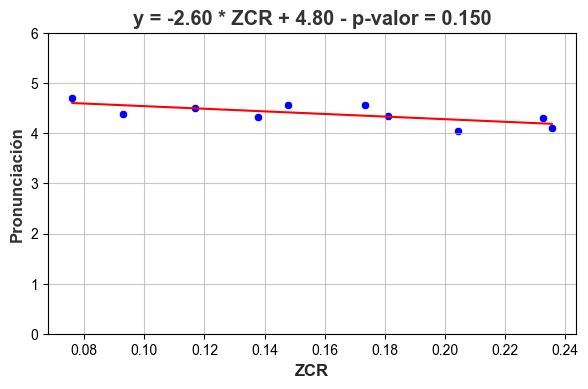

In [137]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Pronunciación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresiones_pronunciacion_female.png'))
    plt.show()


In [138]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Pronunciación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, PRONUNCIACION_FOLDER, FEMALE_FOLDER, 'regresion_pronunciacion_multivariable_female.html')
    )

    fig.show()


### Acentuacion

In [139]:
df_acentuacion = df_union.loc[:, ['Acentuacion', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [140]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'masculino'

df_acentuacion_male = df_acentuacion[mask_gender].drop(columns=['genero'])

In [141]:
# Cargamos los datos
X = np.array(df_acentuacion_male.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_male.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0128
Característica RMS: p-valor = 0.0947
Característica f0: p-valor = 0.3057


In [142]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [143]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -8.04 * ZCR + 5.08 - p-valor = 0.013


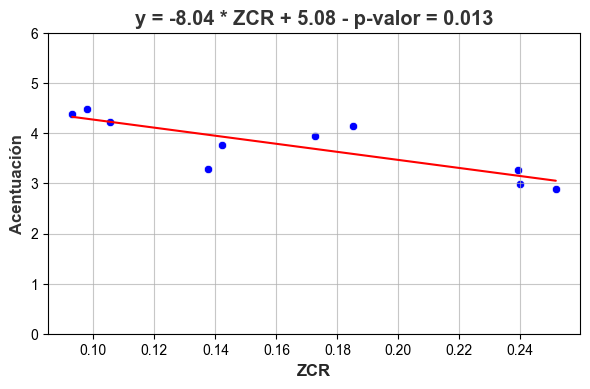

In [144]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresiones_acentuacion_male.png'))
    plt.show()


In [145]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, MALE_FOLDER, 'regresion_acentuacion_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [146]:
# Lista de p-values
p_values = []

mask_gender = df_acentuacion.genero == 'femenino'

df_acentuacion_female = df_acentuacion[mask_gender].drop(columns=['genero'])

In [147]:
# Cargamos los datos
X = np.array(df_acentuacion_female.drop(columns=['Acentuacion'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_acentuacion_female.Acentuacion) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Acentuación')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.5144
Característica RMS: p-valor = 0.3928
Característica f0: p-valor = 0.1201


In [148]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [149]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.18 * RMS + 9.04 - p-valor = 0.393
y = -0.02 * $f_{0}$ + 6.50 - p-valor = 0.120


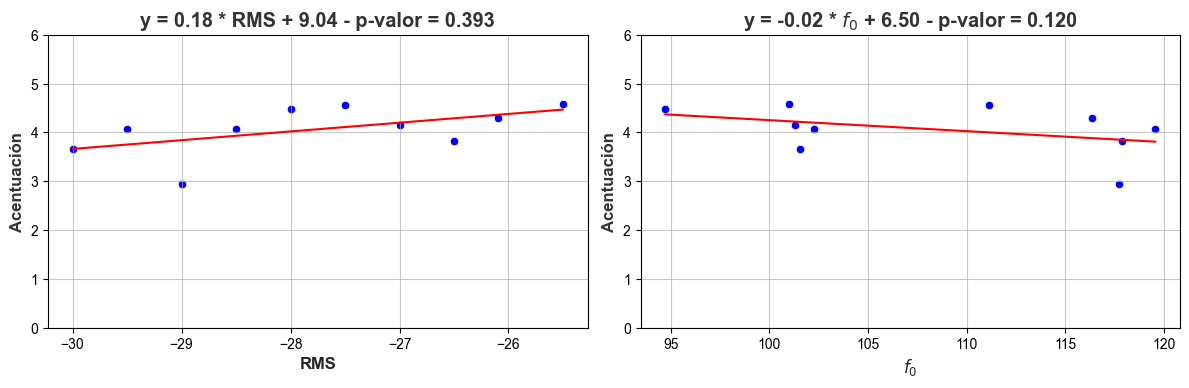

In [150]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Acentuación', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresiones_acentuacion_female.png'))
    plt.show()


In [151]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Acentuación', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, ACENTUACION_FOLDER, FEMALE_FOLDER, 'regresion_acentuacion_multivariable_female.html')
    )

    fig.show()


### Naturalidad

In [152]:
df_naturalidad = df_union.loc[:, ['Naturalidad', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [153]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'masculino'

df_naturalidad_male = df_naturalidad[mask_gender].drop(columns=['genero'])

In [154]:
# Cargamos los datos
X = np.array(df_naturalidad_male.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_male.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0,)
Característica ZCR: p-valor = 0.0180
Característica RMS: p-valor = 0.8911
Característica f0: p-valor = 0.6192


In [155]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [156]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -11.17 * ZCR + 4.58 - p-valor = 0.018


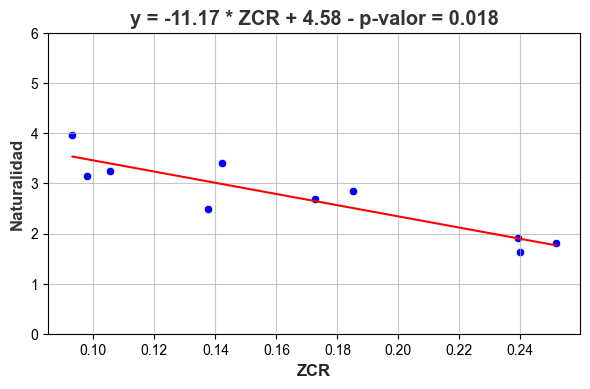

In [157]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresiones_naturalidad_male.png'))
    plt.show()


In [158]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[-24, -23, -22, -21])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, MALE_FOLDER, 'regresion_naturalidad_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [159]:
# Lista de p-values
p_values = []

mask_gender = df_naturalidad.genero == 'femenino'

df_naturalidad_female = df_naturalidad[mask_gender].drop(columns=['genero'])

In [160]:
# Cargamos los datos
X = np.array(df_naturalidad_female.drop(columns=['Naturalidad'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_naturalidad_female.Naturalidad) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Naturalidad')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (1, 2)
Característica ZCR: p-valor = 0.1070
Característica RMS: p-valor = 0.3334
Característica f0: p-valor = 0.0733


In [161]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [162]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = 0.35 * RMS + 12.95 - p-valor = 0.333
y = -0.03 * $f_{0}$ + 5.90 - p-valor = 0.073


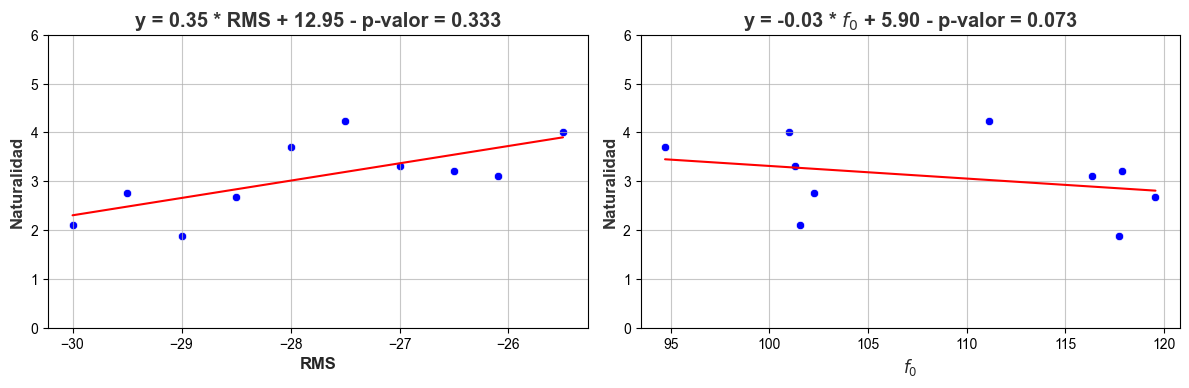

In [163]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Naturalidad', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresiones_naturalidad_female.png'))
    plt.show()


In [164]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Naturalidad', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, NATURALIDAD_FOLDER, FEMALE_FOLDER, 'regresion_naturalidad_multivariable_female.html')
    )

    fig.show()


### Cadencia

In [165]:
df_cadencia = df_union.loc[:, ['Cadencia', 'zcr', 'rms', 'f0', 'genero']]

#### Masculino

In [166]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'masculino'

df_cadencia_male = df_cadencia[mask_gender].drop(columns=['genero'])

In [167]:
# Cargamos los datos
X = np.array(df_cadencia_male.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_male.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('masculino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 2)
Característica ZCR: p-valor = 0.0023
Característica RMS: p-valor = 0.3417
Característica f0: p-valor = 0.9909


In [168]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [169]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -13.77 * ZCR + 5.11 - p-valor = 0.002
y = -0.07 * $f_{0}$ + 7.93 - p-valor = 0.991


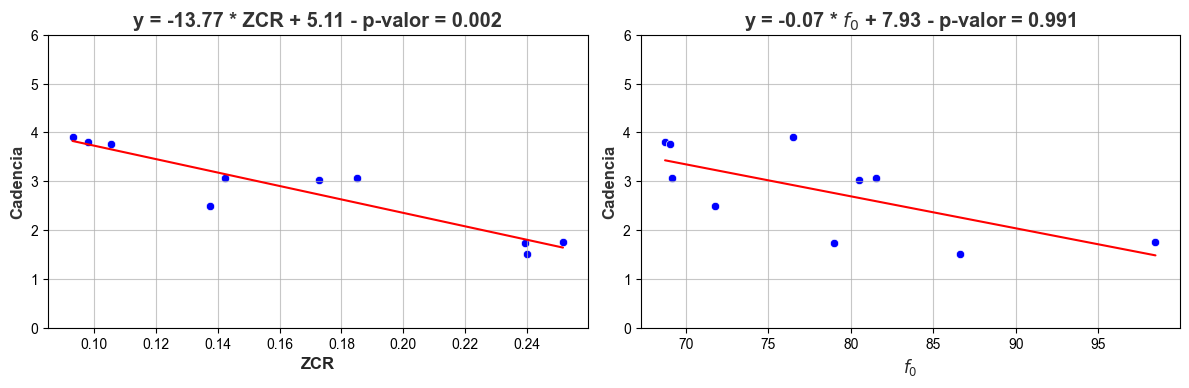

In [170]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresiones_cadencia_male.png'))
    plt.show()


In [171]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[75, 80, 85, 90, 95])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, MALE_FOLDER, 'regresion_cadencia_multivariable_male.html')
    )

    fig.show()


#### Femenino

In [172]:
# Lista de p-values
p_values = []

mask_gender = df_cadencia.genero == 'femenino'

df_cadencia_female = df_cadencia[mask_gender].drop(columns=['genero'])

In [173]:
# Cargamos los datos
X = np.array(df_cadencia_female.drop(columns=['Cadencia'])) # df_objetivos es el DataFrame con los parámetros objetivos
y = np.array(df_cadencia_female.Cadencia) # df_subjetivos es el DataFrame con los parámetros subjetivos

# Creamos el modelo de regresión lineal
regr_multivar = LinearRegression()

# Creamos el selector de características hacia adelante
forward_selector = SequentialFeatureSelector(regr_multivar, k_features='best', forward=True, scoring='neg_mean_squared_error')

# Entrenamos el selector de características
forward_selector.fit(X, y)

# Obtenemos las características seleccionadas
selected_features = forward_selector.k_feature_idx_

# Imprimimos las características seleccionadas
print('Características seleccionadas:', selected_features)

# Agregamos una columna de unos para representar el término de intercepción
X2 = sm.add_constant(X)

# Creamos el modelo OLS (mínimos cuadrados ordinarios) y lo ajustamos a los datos
model = sm.OLS(y, X2)
results = model.fit()

# Imprimimos los p-valores para cada característica seleccionada
for feature, pvalue in zip(list(range(X.shape[1])), results.pvalues[1:]):

    if feature == 0:
        feature = 'ZCR'
    elif feature == 1:
        feature = 'RMS'
    else:
        feature = 'f0'
    
    print(f'Característica {feature}: p-valor = {pvalue:.4f}')

    p_values.append(pvalue)
    dicc_p_value[feature].append(pvalue)

dicc_p_value['subjetive_parameter'].append('Cadencia')
dicc_p_value['genero'].append('femenino')
dicc_p_value['selected_features'].append(list(selected_features))


Características seleccionadas: (0, 1, 2)
Característica ZCR: p-valor = 0.0732
Característica RMS: p-valor = 0.0421
Característica f0: p-valor = 0.0241


In [174]:
# Dicc auxiliar con los nombres asociadas a las variables
dicc_names_features = {
    'zcr_model': 0,
    'rms_model': 1,
    'f0_model': 2
}

# Dicc de los modelos
dicc_model = {}

# Dicc de las predicciones
dicc_pred = {}

for selected_feature in selected_features:
    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X[:, selected_feature].reshape(-1, 1), y.ravel())

    # Almacenamos en dicc_model la clave asociada al modelo que se entrenó y el objeto modelo
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_model[key] = regr_multivar

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X[:, selected_feature].reshape(-1, 1))

    # Almacenamos en dicc_pred la clave asociada al modelo que se entrenó y la predicción
    for key, value in dicc_names_features.items():
        if value == selected_feature:
            dicc_pred[key] = y_pred


In [175]:
list_equ = []

for key, model in dicc_model.items():
    # Obtenemos los valores de w y b
    w = model.coef_[0]
    b = model.intercept_
    
    label = key.replace("_model", "")
    if label == 'f0':
        label = r'$f_{0}$'
    else:
        label = label.upper()

    # Construimos la cadena de texto para la ecuación del hiperplano y su p-valor
    equation = f'y = {w:.2f} * {label} + {b:.2f} - p-valor = {p_values[dicc_names_features[key]]:.3f}'

    # Agregamos la cadena a la lista
    list_equ.append(equation)

# Mostramos el resultado
for equ in list_equ:
    print(equ)


y = -11.20 * ZCR + 5.12 - p-valor = 0.073
y = 0.44 * RMS + 15.44 - p-valor = 0.042
y = -0.02 * $f_{0}$ + 6.01 - p-valor = 0.024


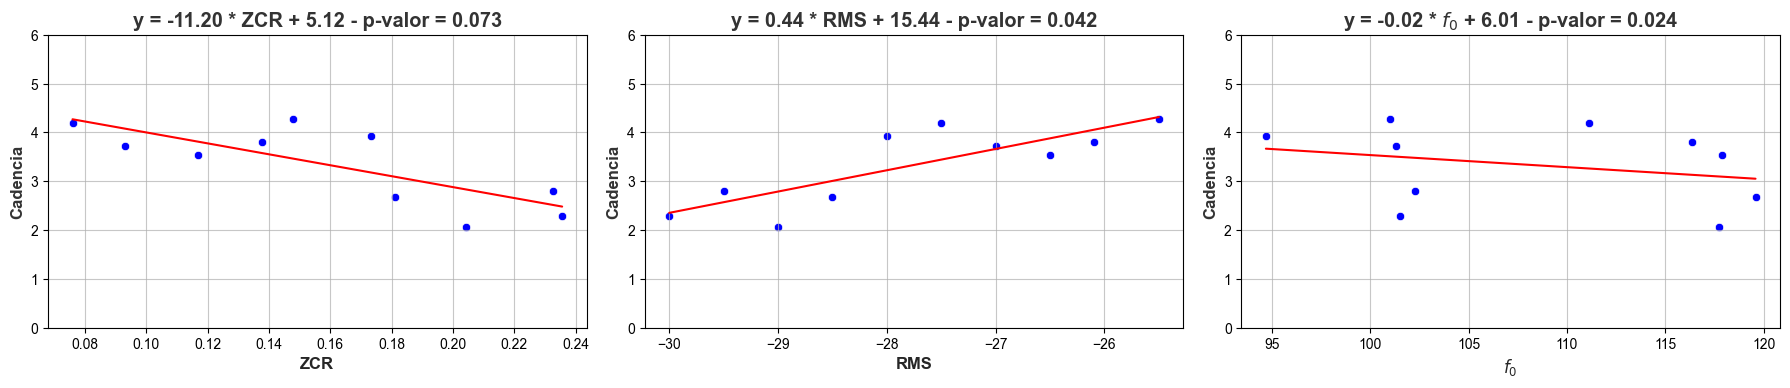

In [176]:
dims = (6 * len(dicc_model), 4)
fig, ax = plt.subplots(figsize=dims, ncols=len(dicc_model))

with sns.axes_style('darkgrid'):
    for i, (key, model) in enumerate(dicc_model.items()):
        if isinstance(ax, np.ndarray):
            ax_i = ax[i]
        else:
            ax_i = ax
        label = key.replace("_model", "")
        if label == 'f0':
            label = r'$f_{0}$'
        else:
            label = label.upper()
        g = sns.scatterplot(x=X[:, dicc_names_features[key]], y=y, ax=ax_i, color='blue')
        g = sns.lineplot(x=X[:, dicc_names_features[key]], y=dicc_pred[key], ax=ax_i, color='red')
        g.text(0.5, -0.1, label, weight='bold', size='large', family='Arial', stretch='extra-expanded', ha='center', va='top', transform=g.transAxes)
        g.set_ylabel('Cadencia', weight='bold', size='large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.set_title(list_equ[i], weight='bold', size='x-large', alpha=0.8, family='Arial', stretch='extra-expanded')
        g.grid(alpha=0.7)
        ax_i.set_ylim(0, 6)

    plt.tight_layout()
    plt.savefig(os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresiones_cadencia_female.png'))
    plt.show()


In [177]:
if len(dicc_model) == 2:
    import plotly.express as px
    import plotly.graph_objects as go

    # Seleccionamos solo las características seleccionadas en X
    X_selected = X[:, selected_features]

    # Entrenamos el modelo de regresión con las características seleccionadas
    regr_multivar = LinearRegression()
    regr_multivar.fit(X_selected, y)

    # Obtenemos las predicciones del modelo para las características seleccionadas
    y_pred = regr_multivar.predict(X_selected)

    # Crear la figura
    fig = px.scatter_3d(x=X_selected[:, 0], y=X_selected[:, 1], z=y)

    # Crear el plano de regresión
    xx, yy = np.meshgrid(X_selected[:, 0], X_selected[:, 1])
    zz = regr_multivar.intercept_ + np.dot(np.array([xx.ravel(), yy.ravel()]).T, regr_multivar.coef_.ravel()).reshape(xx.shape)
    fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5))

    # Construir la cadena de texto para la ecuación del plano
    equation = f'z = {regr_multivar.intercept_.round(2)}'
    for i, (key, model) in enumerate(dicc_model.items()):
        equation += f' + {regr_multivar.coef_[i].round(2)} * {key.replace("_model", "")}'
    
    # Centrar el título
    fig.update_layout(title=dict(text=equation, x=0.5, xanchor='center'))

    # Etiquetas de los ejes y rango del eje z
    fig.update_layout(scene=dict(xaxis_title=list(dicc_model.keys())[0].replace("_model", ""), yaxis_title=list(dicc_model.keys())[1].replace("_model", ""), zaxis_title='Cadencia', zaxis=dict(range=[0, 6]), yaxis=dict(tickvals=[100, 105, 110, 115, 120])))

    fig.write_html(
       os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, CADENCIA_FOLDER, FEMALE_FOLDER, 'regresion_cadencia_multivariable_female.html')
    )

    fig.show()

## Output p-values regressions

In [178]:
df_output_p_value_regression = pd.DataFrame(dicc_p_value)

In [180]:
# Crea un diccionario para mapear los valores
map_dict = {0: 'ZCR', 1: 'RMS', 2: 'F0'}

df_output_p_value_regression['selected_features'] = df_output_p_value_regression['selected_features'].apply(lambda x: [map_dict[val] for val in x])

In [181]:
df_output_p_value_regression

,subjetive_parameter,ZCR,RMS,f0,selected_features,genero
0,Inteligibilidad,0.130069,0.576055,0.699245,[ZCR],masculino
1,Inteligibilidad,0.026715,0.672845,0.127228,"[ZCR, f0]",femenino
2,Pronunciación,0.002332,0.012414,0.118646,"[ZCR, RMS]",masculino
3,Pronunciación,0.150192,0.658306,0.207414,[ZCR],femenino
4,Acentuación,0.012770,0.094656,0.305689,[ZCR],masculino
5,Acentuación,0.514386,0.392788,0.120145,"[RMS, f0]",femenino
6,Naturalidad,0.017957,0.891097,0.619233,[ZCR],masculino
7,Naturalidad,0.107021,0.333371,0.073253,"[RMS, f0]",femenino
8,Cadencia,0.002295,0.341678,0.990921,"[ZCR, f0]",masculino
9,Cadencia,0.073162,0.042053,0.024059,"[ZCR, RMS, f0]",femenino


In [82]:
df_output_p_value_regression.to_excel(
    os.path.join(PATH, TEST_FOLDER, REGGRESSION_FOLDER, PARAMETRIC_FOLDER, 'output_p_values_parametric_regressions.xlsx'),
    index=False
)